In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive"

 Barrons-800.gdoc
 Classroom
'Colab Notebooks'
 Content-Based-Video-Search-TCS.zip
'datasets links'
 fra.txt
'[GigaCourse.com] Udemy - Deep Learning and Computer Vision A-Z™ OpenCV, SSD & GANs'
 glove.6B.100d.txt
 gre
'How to get started with Drive.pdf'
 Icons
 ipgm_project
'jigsaw toxic'
 magoos
'Mike And Dave Need Wedding Dates (2016) [1080p] [YTS.AG]'
'ml resume'
 project
'Research papers (final-year project).gsheet'
'resume certificates.pdf'
 resume.pdf
 TCS_PROJECT
 Untitled0.ipynb
'Untitled document.gdoc'
'Untitled spreadsheet.gsheet'
 videos
 YOLOv3-Object-Detection-with-OpenCV


In [4]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU



Using TensorFlow backend.


In [0]:
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [0]:
# config
BATCH_SIZE = 64
EPOCHS = 30
LATENT_DIM = 400
LATENT_DIM_DECODER = 400 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 20000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100




# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1



In [7]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('/content/drive/My Drive/fra.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))




num samples: 20000


In [8]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)


Found 3514 unique input tokens.


In [9]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


Found 9532 unique output tokens.


In [10]:

# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_data.shape: (20000, 6)
encoder_data[0]: [ 0  0  0  0  0 20]
decoder_data[0]: [ 2 65  5  0  0  0  0  0  0  0  0  0  0]
decoder_data.shape: (20000, 13)


In [11]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('/content/drive/My Drive/glove.6B.100d.txt') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))



Loading word vectors...
Found 400000 word vectors.


In [12]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



Filling pre-trained embeddings...


In [0]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


In [0]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word > 0:
      decoder_targets_one_hot[i, t, word] = 1

In [30]:
##### build the model #####
print("h")
# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
print(x.shape)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 # dropout not available on gpu
))
encoder_outputs = encoder(x)
print(encoder_outputs.shape)


# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))
print(decoder_inputs_placeholder.shape)
# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
print(decoder_inputs_x.shape)


h
(None, 6, 100)
(None, 6, 800)
(None, 13)
(None, 13, 100)


In [0]:
######### Attention #########
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)
  print(st_1.shape)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])
  print(x.shape)
  # Neural net first layer
  x = attn_dense1(x)
  print(x.shape)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)
  print(alphas.shape)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])
  print(context.shape)

  return context


In [0]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)


In [33]:
print(initial_s.shape)

(None, 400)


In [0]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []

In [35]:

for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)


(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)


In [36]:
print(xt.shape)
print(decoder_lstm_input.shape)
print(o.shape)
print(s.shape)
print(c.shape)
print(decoder_outputs.shape)
print(outputs)

(None, 1, 100)
(None, 1, 900)
(None, 400)
(None, 400)
(None, 400)
(None, 9533)
[<tf.Tensor 'dense_6/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_1/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_2/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_3/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_4/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_5/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_6/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_7/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_8/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_9/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_10/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_11/Softmax:0' shape=(None, 9533) dtype=float32>, <tf.Tensor 'dense_6_12/Softmax:0' shape=(None, 9533) dtype=float32>]


In [0]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

In [38]:
# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)
print(outputs.shape)

(None, 13, 9533)


In [0]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)


In [0]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


In [0]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

In [0]:
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])


In [43]:
# train the model
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]
print(z.shape)
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

(20000, 400)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 38s 2ms/step - loss: 5.9843 - acc: 0.2376 - val_loss: 5.9434 - val_acc: 0.2237
Epoch 2/30
16000/16000 [==============================] - 32s 2ms/step - loss: 5.1457 - acc: 0.2743 - val_loss: 5.5162 - val_acc: 0.2345
Epoch 3/30
16000/16000 [==============================] - 33s 2ms/step - loss: 4.6278 - acc: 0.3051 - val_loss: 4.8828 - val_acc: 0.3041
Epoch 4/30
16000/16000 [==============================] - 32s 2ms/step - loss: 3.7067 - acc: 0.4358 - val_loss: 4.1965 - val_acc: 0.4033
Epoch 5/30
16000/16000 [==============================] - 32s 2ms/step - loss: 2.9967 - acc: 0.5089 - val_loss: 3.9223 - val_acc: 0.4430
Epoch 6/30
16000/16000 [==============================] - 32s 2ms/step - loss: 2.4848 - acc: 0.5505 - val_loss: 3.7840 - val_acc: 0.4621
Epoch 7/30
16000/16000 [==============================] - 33s 2ms/step - loss: 2.0645 - acc: 0.5901 - val_loss: 3.6949 - val_acc:

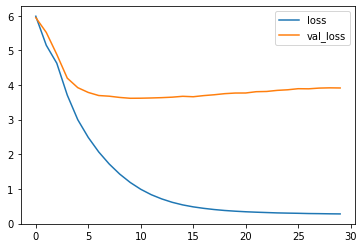

In [44]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [45]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


KeyError: ignored

In [0]:
 # The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

In [49]:
# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
print(encoder_outputs_as_input.shape)
decoder_inputs_single = Input(shape=(1,))
print(decoder_inputs_single.shape)

decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
print(decoder_inputs_single_x.shape)


(None, 6, 800)
(None, 1)
(None, 1, 100)


In [50]:
# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)
print(context.shape)

(None, 6, 400)
(None, 6, 1200)
(None, 6, 10)
(None, 6, 1)
(None, 1, 800)
(None, 1, 800)


In [51]:
# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])
print(decoder_lstm_input.shape)

(None, 1, 900)


In [52]:
# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
print(o.shape)
print(s.shape)
print(c.shape)

decoder_outputs = decoder_dense(o)
print(decoder_outputs.shape)


(None, 400)
(None, 400)
(None, 400)
(None, 9533)


In [0]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)



In [0]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


In [0]:

def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)


In [56]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: I got divorced.
Predicted translation: j'ai divorcé.
Actual translation: J'ai divorcé. <eos>
Continue? [Y/n]Y
-
Input sentence: Sit down, Tom.
Predicted translation: asseyez-vous, tom.
Actual translation: Asseyez-vous, Tom. <eos>
Continue? [Y/n]Y
-
Input sentence: We can't escape.
Predicted translation: nous ne pouvons nous échapper.
Actual translation: Nous ne pouvons nous échapper. <eos>
Continue? [Y/n]Y
-
Input sentence: Now I'm serious.
Predicted translation: maintenant je suis sérieux.
Actual translation: Maintenant je suis sérieux. <eos>
Continue? [Y/n]Y
-
Input sentence: He is a poet.
Predicted translation: c'est un poète.
Actual translation: Il est poète. <eos>
Continue? [Y/n]Y
-
Input sentence: This is awesome.
Predicted translation: c'est fantastique !
Actual translation: C'est fantastique ! <eos>
Continue? [Y/n]Y
-
Input sentence: How's your wife?
Predicted translation: comment va ta femme ?
Actual translation: Comment va ta femme ? <eos>
Continue? [Y/n]Y
-

In [0]:
Y